In [1]:
import numpy as np
import optuna
SEED = 42

import random
import tensorflow as tf

import os
def init_seed(s):
    seed = s
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINSTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINSTIC"] = "1"
    np.random.seed(seed)
    tf.config.experimental.enable_op_determinism()
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

c:\Users\natha\Documents\Git\5th-year-polytech\deep_learning\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train, X_val, X_test = np.random.uniform(0, 1, 1000), np.random.uniform(0, 1, 200), np.random.uniform(0, 1, 200)
y_train, y_val, y_test = np.sin(8*np.pi*X_train), np.sin(8*np.pi*X_val), np.sin(8*np.pi*X_test)

In [3]:
from keras import layers, Sequential, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def objectif(trial):
    init_seed(2025)
    # Hyperparameters
    n_unit1 = trial.suggest_int("unit1", 32, 64)
    n_unit2 = trial.suggest_int("unit2", 64, 128)
    n_unit3 = trial.suggest_int("unit3", 128, 256)
    learning_rate = trial.suggest_float("lr", 10**-4, 10**-1)
    activation = trial.suggest_categorical("activation", ["relu", "selu"])


    # Create Model

    patience = 20

    callbacks = [
        EarlyStopping(monitor = "val_mse", patience = patience),

    ]

    model = Sequential()
    model.add(Input(shape=(1, )))
    model.add(layers.Dense(n_unit1, activation=activation))
    model.add(layers.Dense(n_unit2, activation=activation))
    model.add(layers.Dense(n_unit3, activation=activation))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss = "mse", metrics = ["mse"])
    history = model.fit(X_train, y_train, batch_size=128, epochs=300, validation_data=(X_val, y_val), verbose = 0, callbacks=callbacks)
    epoch = len(history.history["val_mse"])
    val_mse = history.history["val_mse"][-1 if epoch == 300 else -patience - 1]
    return val_mse

study = optuna.create_study(direction = "minimize")
study.optimize(objectif, n_trials = 10)

[I 2025-09-15 10:01:08,717] A new study created in memory with name: no-name-eea9a8f7-18f4-4889-9145-4c1d6c52c348
[I 2025-09-15 10:01:23,688] Trial 0 finished with value: 0.18495269119739532 and parameters: {'unit1': 42, 'unit2': 113, 'unit3': 165, 'lr': 0.048061239167815024, 'activation': 'selu'}. Best is trial 0 with value: 0.18495269119739532.
[I 2025-09-15 10:01:37,018] Trial 1 finished with value: 0.10699518024921417 and parameters: {'unit1': 40, 'unit2': 105, 'unit3': 250, 'lr': 0.014138292802873683, 'activation': 'selu'}. Best is trial 1 with value: 0.10699518024921417.
[I 2025-09-15 10:01:51,561] Trial 2 finished with value: 0.029118947684764862 and parameters: {'unit1': 38, 'unit2': 113, 'unit3': 156, 'lr': 0.00978915015296478, 'activation': 'selu'}. Best is trial 2 with value: 0.029118947684764862.
[I 2025-09-15 10:01:55,403] Trial 3 finished with value: 0.490011990070343 and parameters: {'unit1': 39, 'unit2': 93, 'unit3': 142, 'lr': 0.0795639624361088, 'activation': 'relu'}.

In [ ]:
study.best_params

{'unit1': 61,
 'unit2': 121,
 'unit3': 245,
 'lr': 0.04637553531700971,
 'activation': 'selu'}

In [ ]:
patience = 20
init_seed(2025)
callbacks = [
    EarlyStopping(monitor = "val_mse", patience = patience),
    ModelCheckpoint(
        filepath = "my_best_model" + ".keras",
        monitor = "val_mse",
        mode = "min",
        save_best_only = True,
        verbose = 0
    )
]

model = Sequential()
model.add(Input(shape=(1, )))
model.add(layers.Dense(study.best_params['unit1'], activation=study.best_params['activation']))
model.add(layers.Dense(study.best_params['unit2'], activation=study.best_params['activation']))
model.add(layers.Dense(study.best_params['unit3'], activation=study.best_params['activation']))
model.add(layers.Dense(1))
model.compile(optimizer=Adam(learning_rate=study.best_params['lr']), loss = "val_mse", metrics = ["val_mse"])
history = model.fit(X_train, y_train, batch_size=128, epochs=300, validation_data=(X_val, y_val), verbose = 0, callbacks=callbacks)

In [ ]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


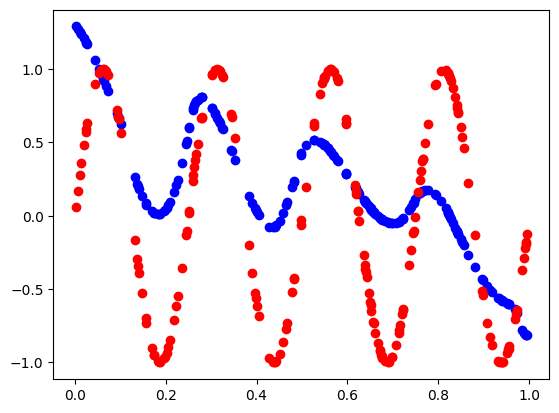

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x = X_test, y = y_pred, color = "blue")
plt.scatter(x = X_test, y = y_test, color = "red")